# Task
Find the actual component values of the bandpass filter in fig. 1.

1. Compare the measured response voltage $U_a$ with the expected response voltage with nominal component values and determine the root mean square error. 
2. Minimize the rmse for different component values to find the actual component values.

![Circuit Diagramm](circuit.png)

In [33]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import scipy as sci

# Get Data

In [40]:
def measured_voltage(filename):    
    # import measured data from file and create DataFrame
    with np.load(filename) as file:
        return pd.DataFrame({"time" : file["t_mess"], "measured" : file["u_a_mess"]})

def calculate_voltage(coil, capacitor, time_points):
    # return calculated voltage by creating LTI System with given parameters
    RESISTOR=20
    INPUT_VOLTAGE = 2

    numerator=[1/(RESISTOR*capacitor), 0]
    denominator=[1, 1/(RESISTOR*capacitor), 1/(coil*capacitor)]
    transfer_function=sci.signal.TransferFunction(numerator, denominator)

    return INPUT_VOLTAGE*sci.signal.step(transfer_function, T=time_points)[1]

u_a = measured_voltage("messwerte.npz")
# append dataframe with expected values
COIL=9e-3
CAPACITOR=1000e-6
u_a["calculated"] = calculate_voltage(COIL, CAPACITOR, u_a["time"])

# Analysis
## Plot Expected and Measured Data

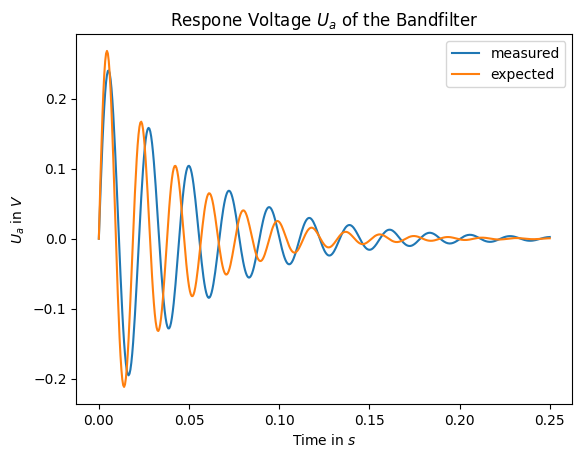

In [45]:
plt.plot(u_a["time"], u_a["measured"], label="measured")
plt.plot(u_a["time"], u_a["calculated"], label='expected')

plt.title("Respone Voltage $U_a$ of the Bandfilter")
plt.xlabel("Time in $s$")
plt.ylabel("$U_a$ in $V$")
plt.legend()

plt.show()

## Calculate Root Mean Square Error

In [46]:
def root_mean_square_error(calculated, true): 
    # Calculate the root mean square error of 2 1D arrays
    return np.round(np.sqrt(1/len(calculated) * np.sum(np.square(np.subtract(calculated, true)))) *10**6, 2)

rsme = root_mean_square_error(u_a["calculated"], u_a["measured"])
print(f"root mean square error with nominal values: {rsme} e-6 V")

root mean square error with nominal values: 64993.98 e-6 V


# Modelling
## Minimize sum of squared error with variable parameters

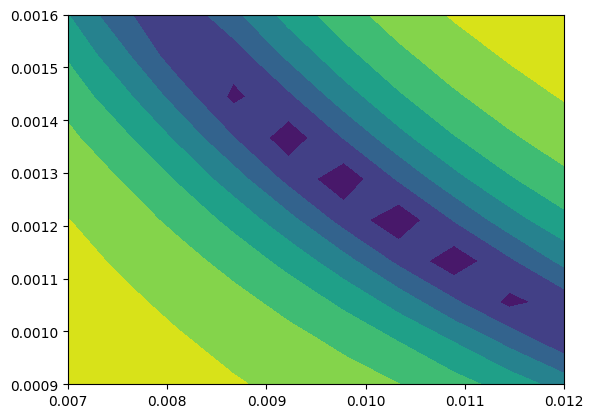

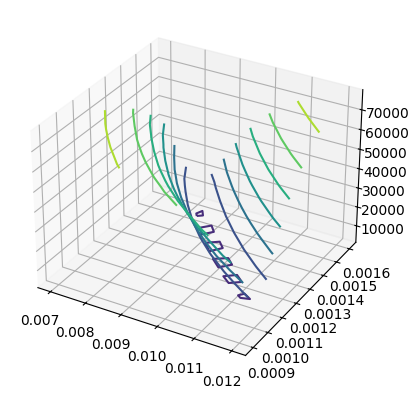

In [47]:
def rsme_array(steps):
    COIL_LOWER = 7e-3
    COIL_UPPER = 12e-3
    CAPACITOR_LOWER = 9 * 100e-6
    CAPACITOR_UPPER = 16 * 100e-6
    coil_list = np.linspace(COIL_LOWER, COIL_UPPER, steps)
    capacitor_list = np.linspace(CAPACITOR_LOWER, CAPACITOR_UPPER, steps) 

    x, y = np.meshgrid(coil_list, capacitor_list)

    Z=np.zeros((steps, steps))
    for i in range(steps):
        for j in range(steps):
            Z[i][j] = root_mean_square_error(calculate_voltage(coil_list[i], capacitor_list[j], u_a["time"]), u_a["measured"])
    return x,y,Z

x,y,Z = rsme_array(10)
plt.contourf(x, y, Z)
ax = plt.figure().add_subplot(projection='3d')
ax.contour(x, y, Z)

In [38]:
# Function to minimize
# def objective_function(params):
#     coil, capacitor = params
#     numerator = [1 / (RESISTOR * capacitor), 0]
#     denominator = [1, 1 / (RESISTOR * capacitor), 1 / (coil * capacitor)]
#     system = signal.lti(numerator, denominator)
#     calculated = VOLTAGE * signal.step(system)[1]
#     return mean_root_error(calculated, u_a["measured"])

# Find the minimum RMSE
# initial_guess = [0.1**3, 0.1**2]  # Initial guess for COIL and CAPACITOR
# result = optimize.minimize(objective_function, x0=initial_guess)
# best_coil, best_capacitor = result.x
# min_rmse = result.fun

# print(f"Optimal COIL: {best_coil}, Optimal CAPACITOR: {best_capacitor}, Minimum RMSE: {min_rmse}")

# plt.contourf(x, y, Z)

# Z_min = sci.optimize.minimize(sum_squared_error, x0=[0.1**3, 0.1**2])